# Toxic Comments Classification


- Detecting toxic comments on social media platforms is important for various reasons. Firstly, it ensures online safety by identifying which helps platforms take appropriate actions to maintain a safer online community. Secondly, it improves user experience by filtering out toxic comments, promoting healthy discussions, and fostering positive interactions. Moreover, it aids in identifying patterns and sources of toxicity, allowing targeted interventions and the development of policies to address underlying issues. Lastly, by promptly addressing toxic comments, businesses can protect their brand reputation and demonstrate a commitment to fostering a positive online environment. Overall, toxic comment classification plays a vital role in creating a healthier digital space for communication and information sharing.



- An NLP pipeline was implemented in this notebook to check if comments include any toxic material, including:
    - Toxic
    - Severe Toxic 
    - Obscene
    - Threat
    - Insult 
    - Identity Hate

# Import Libraries

In [1]:
import pandas as pd
import nltk
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from bs4 import BeautifulSoup
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from sklearn.ensemble import GradientBoostingClassifier
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from imblearn.metrics import geometric_mean_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from collections import Counter
import re
from nltk.corpus import stopwords

-----------------------------------------------------------------------------------

# Load Data

- Loaded the `Toxic_comments_classification` dataset using Pandas. The dataset can be found at https://www.kaggle.com/competitions/jigsaw-toxic-comment-classification-challenge/data

In [2]:
#Load dataset
df = pd.read_csv("E:\\Documents\\Masters\\NLP\\Toxic Comments classification\\train.csv")
df

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0


-----------------------------------------------------------------------------------

# Data Exploration and Preprocessing

- Checked the dimensions of the data
- Reshaped the data to include a new column `is_toxic` which is flagged as 1 (Toxic) if the comment includes any of the toxic classification (Toxic, Severe Toxic, Obscene, Threat, Insult and Identity Hate).
- Dropped all columns except for `comment_text` and `is_toxic` as comments wil be classified as Toxic or Not.
- Checked class distribution of label (`is_toxic`)
    - Data was found highly imbalanced
- Took a sample of 1000 records as the dataset is too large which will be computationally challenging.
- Rechecked class balance of Target class after sampling.

In [28]:
#Shape of the dataset
print("The dimensions of the whole dataset: ", df.shape)

The dimensions of the whole dataset:  (159571, 2)


In [3]:
# Create a new column 'isToxic'
df['isToxic'] = (df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']] == 1).any(axis=1).astype(int)
df.head(20)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,isToxic
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0,1
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0,0


In [4]:
#Dataframe to only include Comment Text and Label (is_toxic)
df=df[["comment_text","isToxic"]].copy()
df

,comment_text,isToxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
...,...,...
159566,""":::::And for the second time of asking, when ...",0
159567,You should be ashamed of yourself \n\nThat is ...,0
159568,"Spitzer \n\nUmm, theres no actual article for ...",0
159569,And it looks like it was actually you who put ...,0


number of each class


0    143346
1     16225
Name: isToxic, dtype: int64

<Axes: >

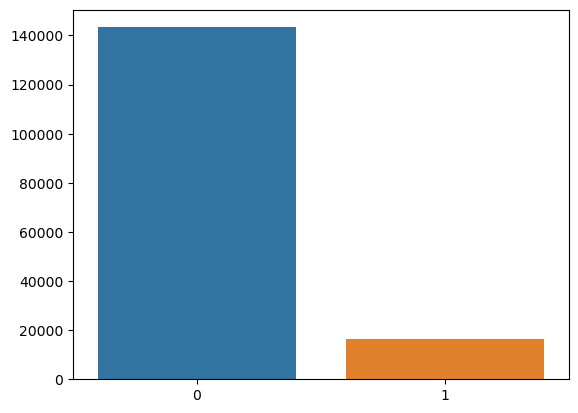

In [5]:
#Class distribution of the label (is_Toxic)
target_count = df["isToxic"].value_counts()
print("number of each class")
display(target_count)
sns.barplot(x=target_count.index, y=target_count.values)

In [6]:
#Taking a sample (1000 records) from the dataset
sample_df=df.sample(1000)
sample_df = sample_df.reset_index(drop=True)
sample_df

,comment_text,isToxic
0,Tagged Image:Aconitethrill.jpg as a promotiona...,0
1,"""\n\n take your own advice \n\nwow, you sure d...",0
2,"""\n\n Title \n\nIs """"FAST"""" supposed to be an ...",0
3,"""\n\nGreat peace-keeping! That solved the prob...",0
4,I intended the comment about multiplicity to b...,0
...,...,...
995,"I have a article that was just published, conf...",0
996,umm \n\nwhy didnt you say why you reverted my ...,0
997,"OrphanBot\nSo, what should we do? We're both w...",0
998,"R u gay? \n\nHi, are you a faggot?",1


number of each class


0    887
1    113
Name: isToxic, dtype: int64

<Axes: >

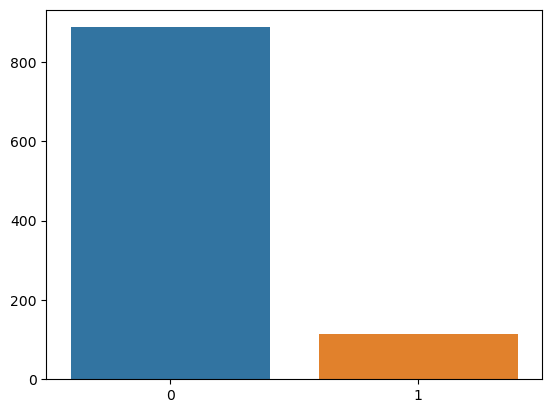

In [7]:
#Class distribution of the label feature (is_Toxic) in the sample
target_count = sample_df["isToxic"].value_counts()
print("number of each class")
display(target_count)
sns.barplot(x=target_count.index, y=target_count.values)

As seen from the plot the data is highly imbalanced which will required applying class balancing techniques (Over-sampling or Under-sampling)

-----------------------------------------------------------------------------------

# Feature Engineering

- Cleaned data by removing URLs, Hashtags and Mentions from Text
- Parsed the data using BeautifulSoup
- Tokenized data to words using word_tokenize
- Removed stop words using the predefined stop words library
- Applied stemming using Porter Stemmer
- Applied text representation using TFIDF Vectorizer

In [8]:
#Initialize porter stemmer
porter = nltk.SnowballStemmer('english')

# Create a Stopword List
stopwords_list = set(stopwords.words('english'))

def preprocessor (input_text):
    # Remove URLs, mentions, and hashtags from the text
    text = re.sub(r'http\S+', '', input_text)
    text = re.sub(r'@\S+', '', text)
    text = re.sub(r'#\S+', '', text)
    #Retrieve Plain text
    parsed_text = BeautifulSoup(text,'html.parser').text
    #Tokenize text
    tokenized_text = nltk.word_tokenize(parsed_text, language = 'english')
    #Remove stopwords
    filtered_tokens = [token for token in tokenized_text if token.lower() not in stopwords_list]
    #Apply stemming using Porter Stemmer
    stems = [porter.stem(t) for t in filtered_tokens]
    return ' '.join(stems)

sample_df['comment_text'] = "<mycomment>" + sample_df["comment_text"] + "</mycomment>"
sample_df['comment_text'] = sample_df["comment_text"].apply(preprocessor)

In [9]:
#Display data after feature engineering
sample_df

,comment_text,isToxic
0,tag imag : aconitethrill.jpg promot photograph .,0
1,"`` take advic wow , sure `` '' talk '' '' , ``...",0
2,`` titl `` '' fast '' '' suppos acronym ? ``,0
3,`` great peace-keep ! solv problem opinion . ™ ``,0
4,intend comment multipl except first line quadr...,0
...,...,...
995,"articl publish , confirm caressa cameron miss ...",0
996,umm didnt say revert edit cole voic wwe ppl sa...,0
997,"orphanbot , ? re want wikipedia . micoolio101",0
998,"r u gay ? hi , faggot ?",1


In [10]:
#Initialize TFIDF Vectoizer
tfidf= TfidfVectorizer(min_df=2)

#Fit and transform data using tfidf
sample_df = sample_df.join(pd.DataFrame(tfidf.fit_transform(sample_df['comment_text']).toarray()))
inverted_index={id: term for term, id in tfidf.vocabulary_.items()}
sample_df.head()

,comment_text,isToxic,0,1,2,3,4,5,6,7,...,2595,2596,2597,2598,2599,2600,2601,2602,2603,2604
0,tag imag : aconitethrill.jpg promot photograph .,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"`` take advic wow , sure `` '' talk '' '' , ``...",0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,`` titl `` '' fast '' '' suppos acronym ? ``,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,`` great peace-keep ! solv problem opinion . ™ ``,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,intend comment multipl except first line quadr...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


-----------------------------------------------------------------------------------

# Train Test split

- Split data into Featured (TFIDF Vector) and Target (`is_toxic`)
- Dropped non-numerical features
- Split data into train, validate and test sets

In [11]:
#Splitting data into Features and Target(is_toxic)
targets = sample_df["isToxic"].values
targets = targets.astype(float)
features = sample_df.drop(['isToxic'], axis=1).copy()

#Dropping non-numerical features
features = features.drop(columns= ["comment_text"])

print("Shape of the whole dataset:", features.shape)
print("Number of features:", features.shape[1])

feature_list= []

for item in features.columns:
    if item in inverted_index:
        feature_list.append(inverted_index[item])
    else:
        feature_list.append(item)

#Ensuring features are of datatype Float
features = features.values
features = features.astype(float)

#Splitting data into Train, Validate and Test sets
x_train_big, x_test, y_train_big, y_test = train_test_split(features,targets ,test_size=0.2, shuffle=True, stratify= targets)
x_train, x_valid, y_train, y_valid = train_test_split(x_train_big, y_train_big, test_size = 0.2, shuffle= True, stratify= y_train_big)

Shape of the whole dataset: (1000, 2605)
Number of features: 2605


-----------------------------------------------------------------------------------

# Class Balancing by Oversampling

- Conducted oversampling by SMOTE
- Conducted oversampling by ADASYN

In [12]:
#Class balancing using SMOTE
x_res,y_res = SMOTE().fit_resample(x_train,y_train)

Number of each class


array([568, 568], dtype=int64)

<Axes: >

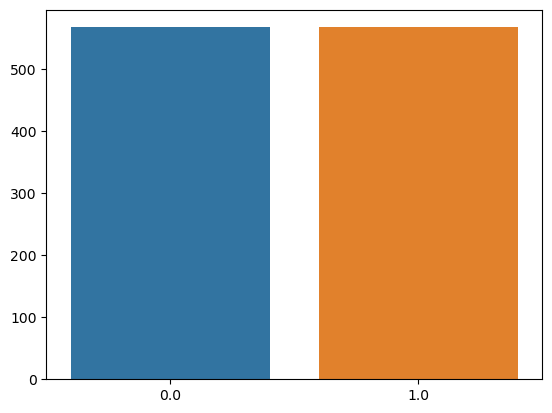

In [26]:
unique_elements, counts = np.unique(y_res, return_counts=True)
print("Number of each class")
display(counts)
sns.barplot(x=unique_elements, y=counts)

In [13]:
#Class balancingusing ADASYN
x_res2,y_res2 = ADASYN().fit_resample(x_train,y_train)

Number of each class


array([568, 562], dtype=int64)

<Axes: >

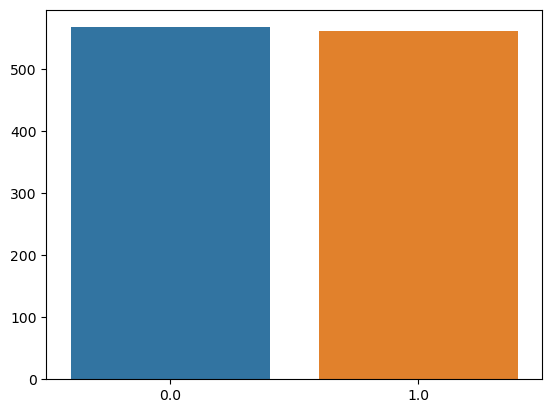

In [27]:
unique_elements, counts = np.unique(y_res2, return_counts=True)
print("Number of each class")
display(counts)
sns.barplot(x=unique_elements, y=counts)

-----------------------------------------------------------------------------------

# Model Training

- Trained different algorithms on imbalanced, balanced using SMOTE and balanced using ADASYN.
- Algorithms tested are:
    - GradientBoostingClassifier
    - XGBClassifier
    - RandomForestClassifier
    - LogisticRegression
    - DecisionTreeClassifier
    - GaussianNB
    - LinearDiscriminantAnalysis
    - KNeighborsClassifier
- Checked best performing algorithm to apply to test data using the score metric F1 

In [14]:
#Calculate product score of all models
def product_score (y_true,y_pred):
    return (geometric_mean_score(y_true,y_pred)* accuracy_score(y_true,y_pred)* f1_score(y_true,y_pred)) ** (1. /3)

#Applying model to imbalanced, balanced using SMOTE and balanced using ADASYN train data
#Calculating Gmean, Accuracy, F1 and Product score for each
def apply_model(clf_class, **kwargs):
    clf = clf_class(**kwargs)
    print (clf_class)
    print ("-------------------------------------------------------------------")
    
    #Fitting classifier with Imbalanced Data
    clf.fit(x_train, y_train)
    pred = clf.predict(x_valid)
    gmean = geometric_mean_score(y_valid, pred)
    acc = accuracy_score(y_valid, pred)
    f1 = f1_score(y_valid, pred)
    prod = product_score(y_valid, pred)

    print ("Imbalanced G-mean = {:.3f}      Accuracy= {:.3f}        f1 = {:.3f}      Product = {:.3f}". format(gmean,acc,f1,prod))
    
    #Fitting classifier with balanced data using SMOTE
    clf.fit(x_res,y_res)
    pred = clf.predict(x_valid)
    gmean = geometric_mean_score(y_valid, pred)
    acc = accuracy_score(y_valid, pred)
    f1 = f1_score(y_valid, pred)
    prod = product_score(y_valid, pred)
    
    print ("SMOTE G-mean = {:.3f}      Accuracy= {:.3f}        f1 = {:.3f}      Product = {:.3f}". format(gmean,acc,f1,prod))
    
    #Fitting classifier with balanced data using ADASYN
    clf.fit(x_res2, y_res2)
    pred = clf.predict(x_valid)
    gmean = geometric_mean_score(y_valid, pred)
    acc = accuracy_score(y_valid, pred)
    f1 = f1_score(y_valid, pred)
    prod = product_score(y_valid, pred)

    print ("ADASYN G-mean = {:.3f}      Accuracy= {:.3f}        f1 = {:.3f}      Product = {:.3f}". format(gmean, acc, f1, prod))

In [15]:
#Applying different models to train data
apply_model(GradientBoostingClassifier)
apply_model(XGBClassifier)
apply_model(RandomForestClassifier)
apply_model(LogisticRegression)
apply_model(DecisionTreeClassifier)
apply_model(GaussianNB)
apply_model(LinearDiscriminantAnalysis)
apply_model(KNeighborsClassifier)

<class 'sklearn.ensemble._gb.GradientBoostingClassifier'>
-------------------------------------------------------------------
Imbalanced G-mean = 0.705      Accuracy= 0.938        f1 = 0.643      Product = 0.752
SMOTE G-mean = 0.740      Accuracy= 0.938        f1 = 0.667      Product = 0.773
ADASYN G-mean = 0.702      Accuracy= 0.931        f1 = 0.621      Product = 0.740
<class 'xgboost.sklearn.XGBClassifier'>
-------------------------------------------------------------------
Imbalanced G-mean = 0.662      Accuracy= 0.925        f1 = 0.571      Product = 0.705
SMOTE G-mean = 0.662      Accuracy= 0.925        f1 = 0.571      Product = 0.705
ADASYN G-mean = 0.660      Accuracy= 0.919        f1 = 0.552      Product = 0.694
<class 'sklearn.ensemble._forest.RandomForestClassifier'>
-------------------------------------------------------------------
Imbalanced G-mean = 0.471      Accuracy= 0.912        f1 = 0.364      Product = 0.539
SMOTE G-mean = 0.575      Accuracy= 0.919        f1 = 0.

As seen above the Logistic Regression using ADASYN balanced data yielded the best scores of:
- Gmean: 0.841,   Accuracy: 0.950,    F1: 0.765,    Product: 0.848

-----------------------------------------------------------------------------------

# Hyperparameter Tuning

- Conducted HyperParameter tuning on logistic regression with the scoring metric of F1

In [16]:
#Initialize parameter grid
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]

    
print ("Manual Grid search Results:\n")
max_f1=0

#Loop over all paramaters in grid and try all different combinations
best_hyper_params= []
for s in solvers:
    for p in penalty:
        for c in c_values:
            model = LogisticRegression(solver=s,penalty=p,C=c)
            model.fit(x_res2,y_res2)
            pred = model.predict (x_valid)
            f1= f1_score(y_valid, pred)
            print ("Solver = ", s,   "              Penalty=", p, "               C= " ,c, "              f1 =", f1)
            if f1>max_f1:
                max_f1 = f1
                best_hyper_params= [s,p,c]
                
print("==============================================================")
print("The best hyper-parameter set:\n")
print(best_hyper_params)    

Manual Grid search Results:

Solver =  newton-cg               Penalty= l2                C=  100               f1 = 0.7272727272727272
Solver =  newton-cg               Penalty= l2                C=  10               f1 = 0.7272727272727272
Solver =  newton-cg               Penalty= l2                C=  1.0               f1 = 0.7647058823529411
Solver =  newton-cg               Penalty= l2                C=  0.1               f1 = 0.6451612903225806
Solver =  newton-cg               Penalty= l2                C=  0.01               f1 = 0.6666666666666667
Solver =  lbfgs               Penalty= l2                C=  100               f1 = 0.7272727272727272
Solver =  lbfgs               Penalty= l2                C=  10               f1 = 0.7272727272727272
Solver =  lbfgs               Penalty= l2                C=  1.0               f1 = 0.7647058823529411
Solver =  lbfgs               Penalty= l2                C=  0.1               f1 = 0.6451612903225806
Solver =  lbfgs          

-----------------------------------------------------------------------------------

# Suggested Predictive Model Performance

- Trained the logistic regression model using the best parameters.
- Applied the model on test data.
- Evaluated the model performance using Classification Report.

In [17]:
x_big_res,y_big_res = ADASYN().fit_resample(x_train_big,y_train_big)

model = LogisticRegression(solver=best_hyper_params[0],penalty=best_hyper_params[1],C=best_hyper_params[2])
print("Suggested predictive model is:\n")
display(model)

#Train with SMOTE
model.fit(x_big_res,y_big_res)

pred= model.predict(x_test)

print("\nClassification Report:")
print (classification_report(y_test, pred))
print("---------------------------------------------------")

gmean= geometric_mean_score(y_test,pred)
acc = accuracy_score(y_test, pred)
f1 = f1_score(y_test, pred)
prod = product_score(y_test, pred)

print ("Test G-mean = {:.2f}      Accuracy= {:.2f}        f1 = {:.2f}      Product = {:.3f}". format(gmean,acc,f1,prod))

Suggested predictive model is:



LogisticRegression(solver='newton-cg')


Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      0.97      0.96       177
         1.0       0.72      0.57      0.63        23

    accuracy                           0.93       200
   macro avg       0.83      0.77      0.80       200
weighted avg       0.92      0.93      0.92       200

---------------------------------------------------
Test G-mean = 0.74      Accuracy= 0.93        f1 = 0.63      Product = 0.758


-----------------------------------------------------------------------------------

# Feature Importance Analysis

- Displayed the Top 15 most important words to classify a text as `is_Toxic`

Top 15 important features:


<Axes: >

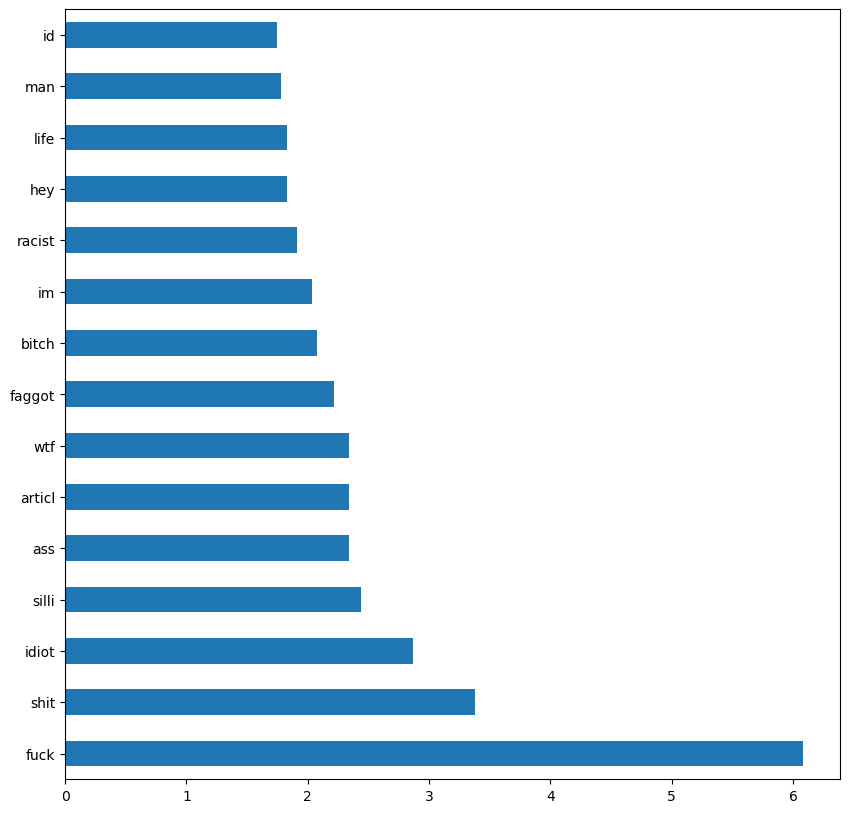

In [18]:
print("Top 15 important features:")

# Get the absolute coefficients of the logistic regression model
feature_importance = np.abs(model.coef_[0])

# Create a pandas Series with feature importances
feat_importances = pd.Series(feature_importance, index=feature_list)

# Select the top 15 important features
feat_importances = feat_importances.nlargest(15)

# Plot the feature importances
feat_importances.plot(kind="barh", figsize=(10, 10))

-----------------------------------------------------------------------------------

# Conclusion

- After conducting data exploration, data preprocessing, feature engineering, class balancing and hyperparameter tuning, the data was trained using logistic regression classifier and yielded accuracy of 93%.
- For future recommendation:
    - Implementing Neural Networks can capture complex patterns in the data and perform better.
